In [84]:
suppressMessages(library(Seurat))
suppressMessages(library(scMEGA))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(ArchR))
suppressMessages(library(Nebulosa))
suppressMessages(library(cowplot))
suppressMessages(library(destiny))
suppressMessages(library(anndataR))

In [85]:
out_dir <- "../../results/05_fibroblast/04_trajectory"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

In [86]:
adata <- anndataR::read_h5ad('../../results/05_fibroblast/01_clustering/fibroblast.h5ad')

In [87]:
adata

AnnData object with n_obs × n_vars = 38895 × 15275
    obs: 'patient_id', 'condition', 'cell_type', 'data', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sub_clusters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [88]:
# convert data to Seurat object
counts <- t(as.matrix(adata$layers$counts))
colnames(counts) <- adata$obs_names
rownames(counts) <- adata$var_names

metadata <- as.data.frame(adata$obs)
obj <- CreateSeuratObject(counts = counts, assay = "RNA")
obj <- AddMetaData(obj, metadata)

# add PCA and UMAP
df_pca <- as.matrix(adata$obsm$X_pca_harmony)
rownames(df_pca) <- adata$obs_names

df_umap <- as.matrix(adata$obsm$X_umap)
rownames(df_umap) <- adata$obs_names

obj[["PCA"]] <- CreateDimReducObject(embeddings = df_pca, 
                                             key = "PCA_", 
                                             assay = DefaultAssay(obj))

obj[["UMAP"]] <- CreateDimReducObject(embeddings = df_umap, 
                                             key = "UMAP_", 
                                             assay = DefaultAssay(obj))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.4 GiB”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“No columnames present in cell embeddings, setting to 'PCA_1:50'”
Warning message:
“No columnames present in cell embeddings, setting to 'UMAP_1:2'”


In [89]:
obj <- NormalizeData(obj)

Normalizing layer: counts



In [90]:
cols <- ArchR::paletteDiscrete(obj@meta.data[, "sub_clusters"])

cols

Fib1      Fib2      Fib3      Fib4      Fib5      Fib6      Fib7      Fib8 
"#D51F26" "#272E6A" "#208A42" "#89288F" "#F47D2B" "#FEE500" "#8A9FD1" "#C06CAB" 
     Fib9     Fib10 
"#D8A767" "#90D5E4"

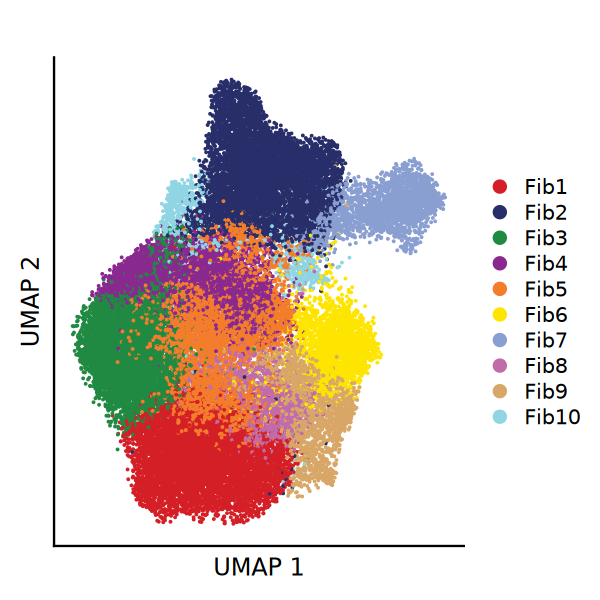

In [91]:
options(repr.plot.height = 5, repr.plot.width = 5)

p <- DimPlot(obj, reduction = 'UMAP', group.by = 'sub_clusters', cols=cols) + 
    ggtitle("") + 
    xlab("UMAP 1") + ylab("UMAP 2") + 
    theme(axis.ticks = element_blank(), axis.text = element_blank())

print(p)

In [92]:
Idents(obj) <- obj@meta.data$sub_clusters

In [93]:
obj <- AddTrajectory(object = obj, 
                     trajectory = c('Fib1', 'Fib3', 'Fib5', 'Fib4', 'Fib10', 'Fib2'),
                     group.by = "sub_clusters", 
                     reduction = "PCA",
                     dims = 1:30, 
                     use.all = FALSE)

# we only plot the cells that are in this trajectory
# obj.sub <- obj.sub[, !is.na(obj.sub$Trajectory)]

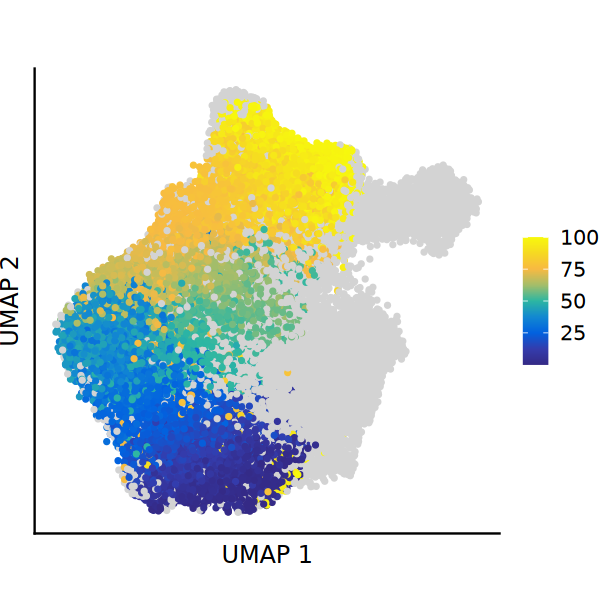

In [94]:
p <- TrajectoryPlot(object = obj, 
                    reduction = "UMAP",
                    continuousSet = "blueYellow",
                    size = 1,
                    addArrow = FALSE) + xlab("UMAP 1") + ylab("UMAP 2") + ggtitle('')

p

In [95]:
df <- obj@meta.data %>%
    as.data.frame() %>%
    subset(., !is.na(Trajectory)) %>%
    group_by(condition) %>%
    mutate(time_point = cut(Trajectory, 
                            breaks = seq(0, 100, 5), 
                            labels = seq(1, 20, 1))) %>%
    ungroup() %>%
    group_by(condition, time_point) %>%
    summarise(num_cells = n()) %>%
    mutate(cell_proportion = num_cells / sum(num_cells)) %>%
    mutate(time_point = 5*as.numeric(time_point))

`summarise()` has grouped output by 'condition'. You can override using the
`.groups` argument.


In [96]:
head(df)

condition,time_point,num_cells,cell_proportion
<fct>,<dbl>,<int>,<dbl>
Control,5,642,0.05519257
Control,10,825,0.07092503
Control,15,910,0.07823246
Control,20,898,0.07720083
Control,25,857,0.07367607
Control,30,774,0.06654058


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


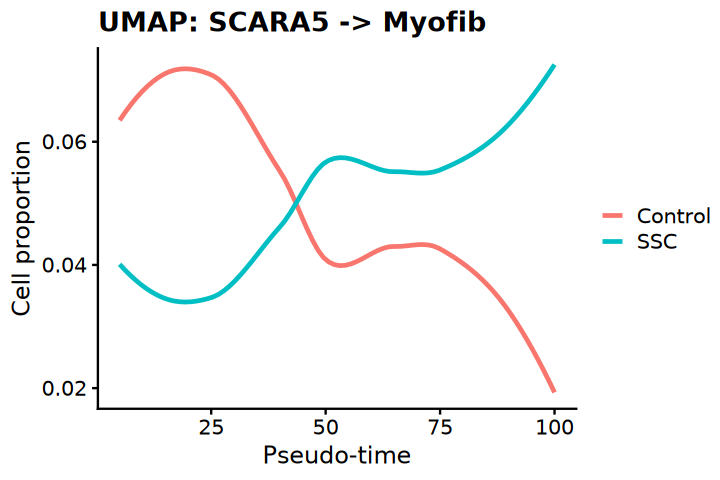

In [97]:
options(repr.plot.height = 4, repr.plot.width = 6)

p <- ggplot(data = df, aes(x = time_point, y = cell_proportion, color = condition)) +
    geom_smooth(se = FALSE) + ggtitle("UMAP: SCARA5 -> Myofib") +
    xlab("Pseudo-time") + ylab("Cell proportion") +
    theme_cowplot() +
    theme(legend.title = element_blank())

print(p)

In [98]:
traj <- GetTrajectory(obj, assay = 'RNA', smoothWindow = 11)

Creating Trajectory Group Matrix..

Smoothing...



In [99]:
ht <- TrajectoryHeatmap(traj, labelTop=100, varCutOff=0.9, pal=ArchR::paletteContinuous(set = "horizonExtra", n = 100))

Removing rows without peaks...

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



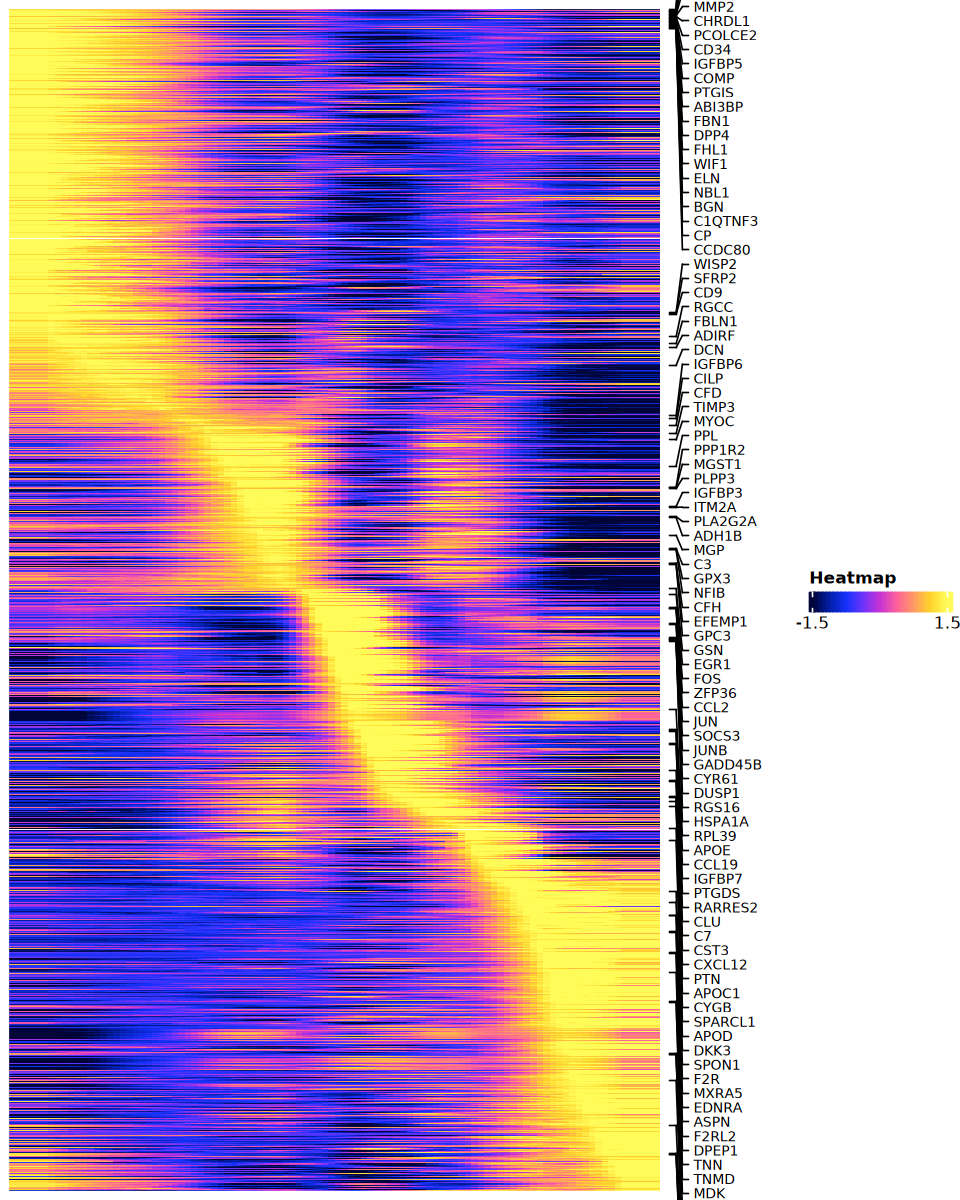

In [100]:
options(repr.plot.height = 10, repr.plot.width = 8)

draw(ht)

In [101]:
ht <- TrajectoryHeatmap(traj, labelMarkers=c("ELN", "CTHRC1"), labelTop=0, varCutOff=0.9, pal=ArchR::paletteContinuous(set = "horizonExtra", n = 100))

Removing rows without peaks...

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



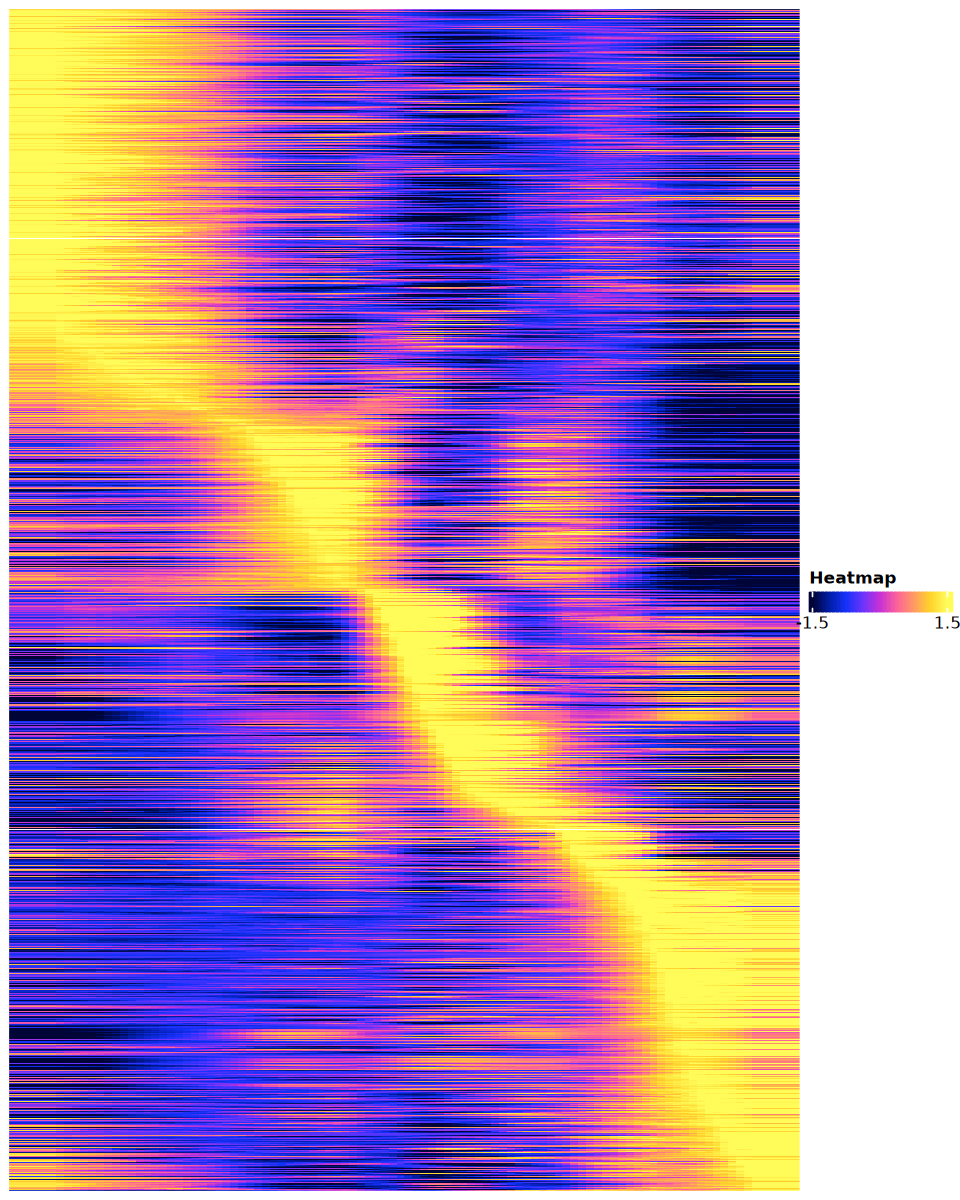

In [102]:
options(repr.plot.height = 10, repr.plot.width = 8)

draw(ht)

In [103]:
saveRDS(obj, glue::glue('{out_dir}/fibroblast.traj.rds'))